In [3]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,  LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import catboost
import seaborn as sns
import matplotlib.pyplot as plt


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/D21/data.csv")

In [6]:
print(df.isnull().sum())

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


In [7]:
df.dtypes

,0
age,int64
sex,int64
chest pain type,int64
resting bp s,int64
cholesterol,int64
fasting blood sugar,int64
resting ecg,int64
max heart rate,int64
exercise angina,int64
oldpeak,float64


In [8]:
df.shape

(1190, 12)

In [9]:
df.columns

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')

In [72]:
# Round the 'old_peak' column to integers
df['oldpeak'] = df['oldpeak'].round().astype(int)

# Display the updated DataFrame
print(df['oldpeak'].head())

0    0
1    1
2    0
3    2
4    0
Name: oldpeak, dtype: int64


In [73]:
df.head(2)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0,1,0
1,49,0,3,160,180,0,0,156,0,1,2,1


In [74]:
df.to_csv('/content/drive/MyDrive/D21/encoded_data.csv', index=False)


In [75]:
# Strip any leading/trailing spaces from the column names
df.columns = df.columns.str.strip()

# Features (X) and target (y)
X = df.drop(columns=["target"])  # All columns except target
y = df["target"]  # Target column

# Verify the selected columns
print(X.head())


   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  
0            0             172                0        0         1  
1            0             156                0        1         2  
2            1              98                0        0         1  
3            0             108                1        2         2  
4            0             122                0        0         1  


Class Distribution:
target
1    629
0    561
Name: count, dtype: int64

Class Percentages:
target
1    52.857143
0    47.142857
Name: proportion, dtype: float64


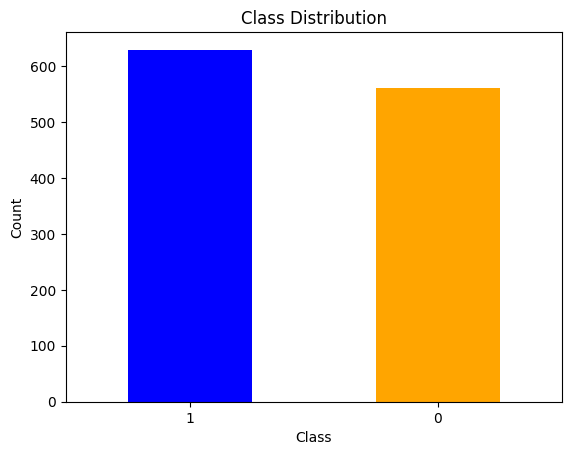

In [76]:
# Check the counts of each class
class_distribution = y.value_counts()

# Calculate percentages
class_percentages = y.value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_distribution)
print("\nClass Percentages:")
print(class_percentages)

# Optional: Visualize
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [77]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [78]:
# Split the data for evaluation (adjust if needed)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [79]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (important: do not fit on test data)
X_test = scaler.transform(X_test)



In [80]:
from sklearn.neural_network import MLPClassifier

mlp_tuned = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=2000, random_state=42, solver='adam', learning_rate='adaptive')
mlp_tuned.fit(X_train, y_train)
mlp_pred_tuned = mlp_tuned.predict(X_test)
mlp_tuned_accuracy = accuracy_score(y_test, mlp_pred_tuned)
print(f"Tuned MLP Accuracy: {mlp_tuned_accuracy * 100:.2f}%")


Tuned MLP Accuracy: 89.68%


In [81]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier()
hgb.fit(X_train, y_train)
hgb_pred = hgb.predict(X_test)
hgb_accuracy = accuracy_score(y_test, hgb_pred)
print(f"Histogram-based Gradient Boosting Accuracy: {hgb_accuracy * 100:.2f}%")


Histogram-based Gradient Boosting Accuracy: 91.01%


In [82]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define the base models
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('svc', SVC(probability=True)),
    ('logreg', LogisticRegression())
]

# Create a stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_pred)
print(f"Stacking Classifier Accuracy: {stacking_accuracy * 100:.2f}%")


Stacking Classifier Accuracy: 93.39%


In [83]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC


# 1. Logistic Regression Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_pred)
print(f"Logistic Regression Accuracy: {logreg_accuracy * 100:.2f}%")

# 2. Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# 3. Support Vector Classifier (SVC)
svc = SVC(probability=True)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, svc_pred)
print(f"SVC Accuracy: {svc_accuracy * 100:.2f}%")

# 4. Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f"Gradient Boosting Accuracy: {gb_accuracy * 100:.2f}%")

# 5. Voting Classifier (Hybrid Model)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('svc', svc),
    ('gb', gb)
], voting='soft')

voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print(f"Voting Classifier Accuracy: {voting_accuracy * 100:.2f}%")




Logistic Regression Accuracy: 85.19%
Random Forest Accuracy: 92.59%
SVC Accuracy: 90.21%
Gradient Boosting Accuracy: 90.21%
Voting Classifier Accuracy: 91.53%


In [84]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize Bagging Classifier with Decision Tree
# Use 'estimator' instead of 'base_estimator'
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)

# Predictions and accuracy
bagging_pred = bagging_model.predict(X_test)
bagging_accuracy = accuracy_score(y_test, bagging_pred)
print(f"Bagging Classifier Accuracy: {bagging_accuracy * 100:.2f}%")

Bagging Classifier Accuracy: 91.80%


In [85]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Initialize Multi-layer Perceptron (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Predictions and accuracy
mlp_pred = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
print(f"MLP Accuracy: {mlp_accuracy * 100:.2f}%")

MLP Accuracy: 90.48%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [87]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
XGB_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {XGB_accuracy * 100:.2f}%")


XGBoost Accuracy: 91.27%


In [88]:
# 5. K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print(f"KNN Accuracy: {knn_accuracy * 100:.2f}%")

KNN Accuracy: 88.36%


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# ---------------------------
# Neural Network (CNN) - Separate Model
# ---------------------------
cnn_model = Sequential()
cnn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Model Accuracy: {cnn_accuracy[1] * 100:.2f}%")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6753 - loss: 0.6229
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8255 - loss: 0.4686
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8249 - loss: 0.4225 
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8408 - loss: 0.3824 
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8535 - loss: 0.3681 
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8436 - loss: 0.3922 
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.3726 
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8246 - loss: 0.4162 
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.3890 
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8705 - loss: 0.3403 
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8621 - loss: 0.3443
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

In [90]:
# 7. AdaBoost Classifier
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train, y_train)
adaboost_pred = adaboost.predict(X_test)
adaboost_accuracy = accuracy_score(y_test, adaboost_pred)
print(f"AdaBoost Accuracy: {adaboost_accuracy * 100:.2f}%")

AdaBoost Accuracy: 87.04%


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [91]:
# 8. Extra Trees Classifier
et = ExtraTreesClassifier(random_state=42)
et.fit(X_train, y_train)
et_pred = et.predict(X_test)
et_accuracy = accuracy_score(y_test, et_pred)
print(f"Extra Trees Accuracy: {et_accuracy * 100:.2f}%")

Extra Trees Accuracy: 91.53%


In [92]:
#11. CatBoost Classifier
catboost_model = catboost.CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)
catboost_accuracy = accuracy_score(y_test, catboost_pred)
print(f"CatBoost Accuracy: {catboost_accuracy * 100:.2f}%")

CatBoost Accuracy: 92.06%


In [93]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define individual models
logreg = LogisticRegression()
rf = RandomForestClassifier()
svc = SVC(probability=True)

# Initialize Voting Classifier
voting_clf = VotingClassifier(estimators=[('logreg', logreg), ('rf', rf), ('svc', svc)], voting='soft')
voting_clf.fit(X_train, y_train)

# Predictions and accuracy
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print(f"Voting Classifier Accuracy: {voting_accuracy * 100:.2f}%")

Voting Classifier Accuracy: 90.48%


In [94]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
LGB_accuracy = accuracy_score(y_test, lgb_pred)
print(f"LGBoost Accuracy: {LGB_accuracy * 100:.2f}%")



[LightGBM] [Info] Number of positive: 432, number of negative: 448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 880, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490909 -> initscore=-0.036368
[LightGBM] [Info] Start training from score -0.036368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBoost Accuracy: 92.59%


In [95]:
# Save the models
joblib.dump(stacking_clf, 'stacking_clf.pkl')
joblib.dump(catboost_model, 'catboost_model.pkl')
joblib.dump(voting_clf, 'voting_model.pkl')

['voting_model.pkl']

Confusion matrix

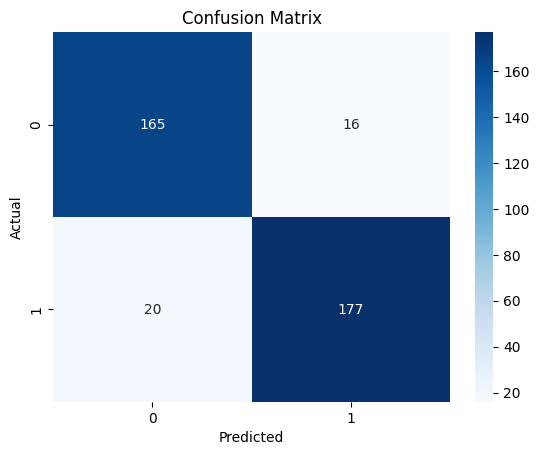

In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, voting_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

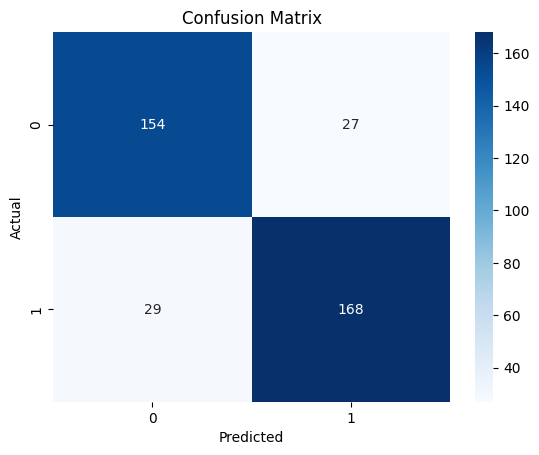

In [98]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, logreg_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

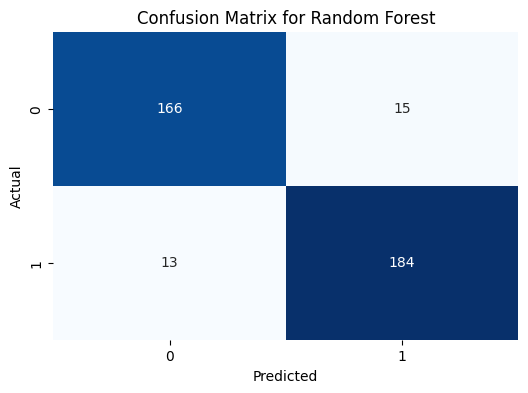

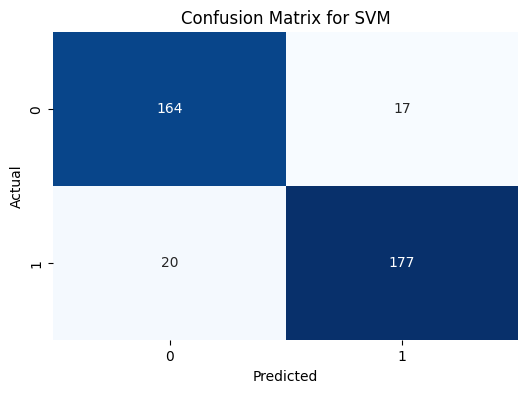

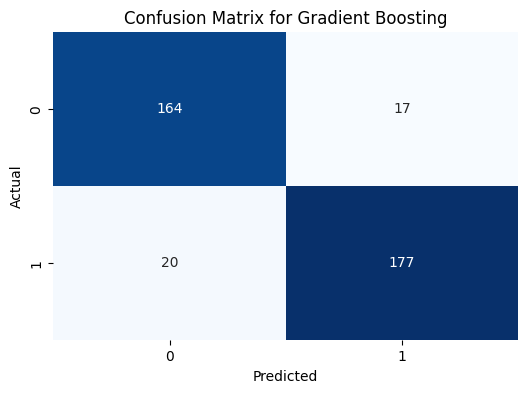

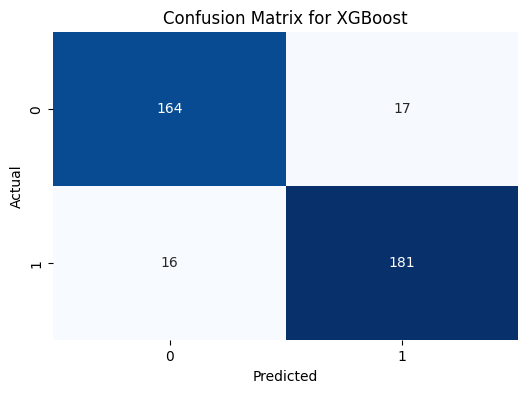

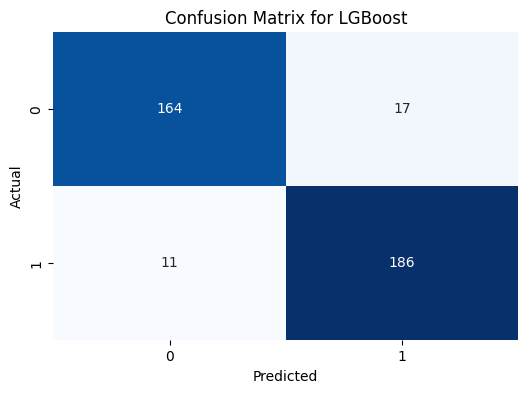

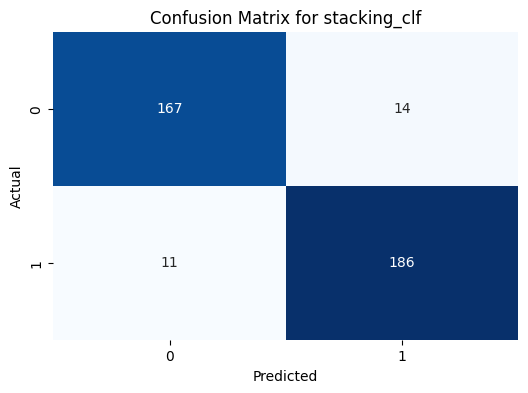

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rf_pred, svc_pred, and gb_pred are predictions from Random Forest, SVM, and Gradient Boosting models
predictions = {'Random Forest': rf_pred, 'SVM': svc_pred, 'Gradient Boosting': gb_pred, 'XGBoost': xgb_pred, 'LGBoost': lgb_pred, 'stacking_clf': stacking_pred}

for model_name, pred in predictions.items():
    cm = confusion_matrix(y_test, pred)  # Calculate the confusion matrix
    plt.figure(figsize=(6, 4))  # Adjust figure size if needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


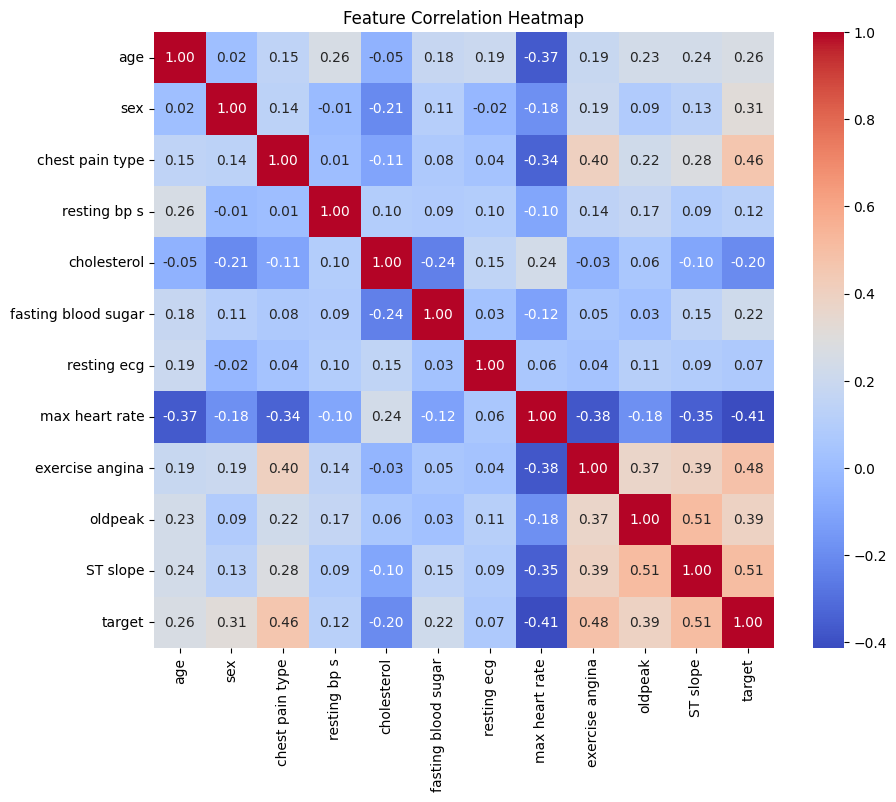

In [100]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

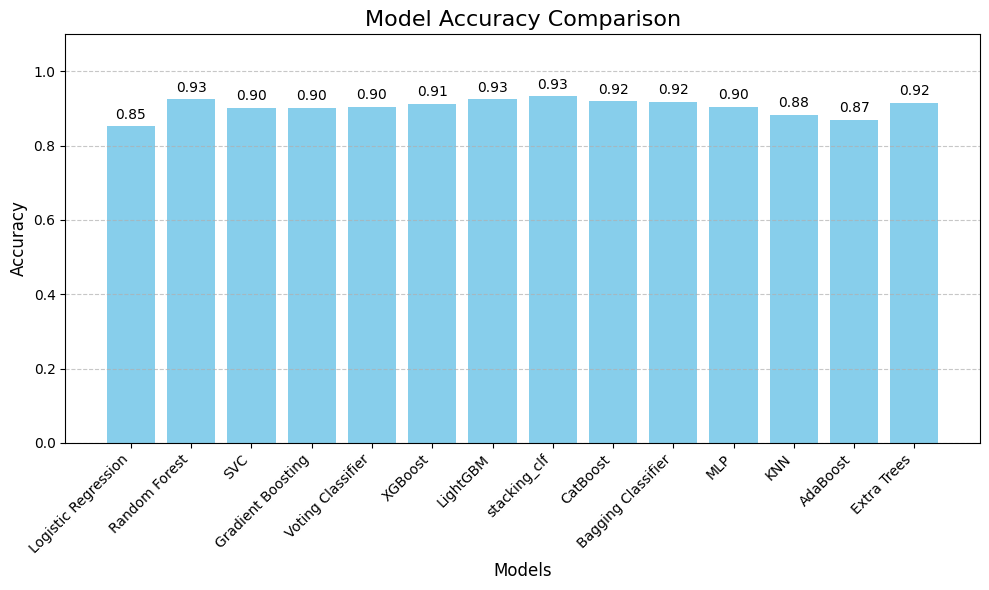

In [102]:
import matplotlib.pyplot as plt

# Assuming you have already calculated these accuracies
model_accuracies = {
    'Logistic Regression': logreg_accuracy,
    'Random Forest': rf_accuracy,
    'SVC': svc_accuracy,
    'Gradient Boosting': gb_accuracy,
    'Voting Classifier': voting_accuracy,
    'XGBoost': XGB_accuracy,
    'LightGBM': LGB_accuracy,
    'stacking_clf': stacking_accuracy,
    'CatBoost': catboost_accuracy,
    'Bagging Classifier': bagging_accuracy,
    'MLP': mlp_accuracy,
    'KNN': knn_accuracy,
    'AdaBoost': adaboost_accuracy,
    'Extra Trees': et_accuracy
}


# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)  # Set y-axis limit slightly above 1 for better text placement
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding accuracy values above the bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height() + 0.02,  # Y-coordinate (just above the bar)
        f'{bar.get_height():.2f}',  # Format accuracy to 2 decimal places
        ha='center',  # Horizontal alignment
        fontsize=10,  # Font size
        color='black'  # Text color
    )

plt.tight_layout()  # Ensures labels fit within the figure
plt.show()
